In [1]:
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import metpy
import metpy.calc as mpycalc
from metpy.units import units
from wetbulb_dj08_spedup import WetBulb
import time
import glob
import pandas as pd
import cmasher as cmr
import netCDF4

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def mask(datos,tipo): #tipo=0 
    if tipo==0:
        mask_Had=xr.open_dataset("/home/andreagvc/data/CMIP/Data/sftlf_fx_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn.nc")
        scoor_Had=mask_Had.sftlf.sel(lon=slice(datos.lon.min(),datos.lon.max()),lat=slice(datos.lat.min(),datos.lat.max()))
        scoor_Had['lon']=datos.lon[1:]
        scoor_Had['lat']=datos.lat
        Land=datos.where(scoor_Had>2,drop=True)
        return Land
    if tipo==1:
        mask_GFDL=xr.open_dataset("/home/andreagvc/data/CMIP/Data/sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr2.nc")
        scoor_GFDL=mask_GFDL.sftlf.sel(lon=slice(datos.lon.min(),datos.lon.max()),lat=slice(datos.lat.min(),datos.lat.max()))
        #scoor_Had['lon']=datos.lon
        #scoor_Had['lat']=datos.lat
        Land=datos.where(scoor_GFDL>3,drop=True)
    
        return Land
    

In [3]:
#HadGEM originales de Tw
HadGEM_histo=xr.open_dataset("cal_historical_HADGEM.nc")
HadGEM_ssp585=xr.open_dataset("cal_ssp585_HADGEM.nc")

In [4]:
HadGEM_histo=HadGEM_histo.where(HadGEM_histo.time.dt.year>1983,drop=True).mean("time")
HadGEM_ssp585=HadGEM_ssp585.where(HadGEM_ssp585.time.dt.year>1969,drop=True).mean("time")

In [5]:
Had_histo=mask(HadGEM_histo,0)
Had_ssp585=mask(HadGEM_ssp585,0)

In [6]:
Had_histo.Tw

<xarray.DataArray 'Tw' (lat: 58, lon: 57)> Size: 26kB
array([[         nan,          nan,          nan, ..., 296.76662455,
        294.74969086, 293.28650448],
       [         nan,          nan,          nan, ..., 296.46833961,
        294.45893459, 294.14267384],
       [         nan,          nan,          nan, ..., 296.43129749,
        293.92554301, 294.00983871],
       ...,
       [         nan, 284.76585663, 284.24710215, ..., 285.67939247,
        285.98541935, 286.72907258],
       [285.19412993, 284.3023853 , 284.52296774, ..., 285.10093459,
        285.45763172, 286.17499642],
       [284.82970968, 284.63021326, 284.37819713, ..., 284.63204211,
        285.14139785,          nan]])
Coordinates:
  * lon        (lon) float64 456B 237.9 238.8 239.6 240.4 ... 282.9 283.7 284.6
  * lat        (lat) float64 464B 5.278 5.833 6.389 6.944 ... 35.83 36.39 36.94
    longitude  (lon) float64 456B 237.9 238.8 239.6 240.4 ... 282.9 283.7 284.6
    latitude   (lat) float64 464B 5.278 5.833 6.389 6.944 ... 35.83 36.39 36.94
    height     float64 8B 1.5
    type       |S4 4B b'land'

In [7]:
#qhistórica HadGEM
qh=xr.open_dataset("twf_qh_HAD.nc")
qh_mask_Had=mask(qh,0)

#qscenario HadGEM
qs=xr.open_dataset("twf_qs1_Had.nc")
qs_mask_Had=mask(qs,0)

In [8]:
#Abriendo los netcdf
Tqh=qh_mask_Had
Tqs=qs_mask_Had
TV=Had_histo.Tw-273.15
TS=Had_ssp585.Tw-273.15

In [9]:
#Delta entre escenario e histórico
d_TW=TS-TV

In [10]:
#Fracción tomando en cuenta q histórica
frac1=(Tqh.__xarray_dataarray_variable__-TV)/d_TW

In [11]:
#Fracción tomando en cuenta q scenario
frac2=(Tqs.__xarray_dataarray_variable__-TV)/d_TW

In [12]:
frac2.max()

<xarray.DataArray ()> Size: 8B
array(1.34824533)
Coordinates:
    type     |S4 4B b'land'
    height   float64 8B 1.5

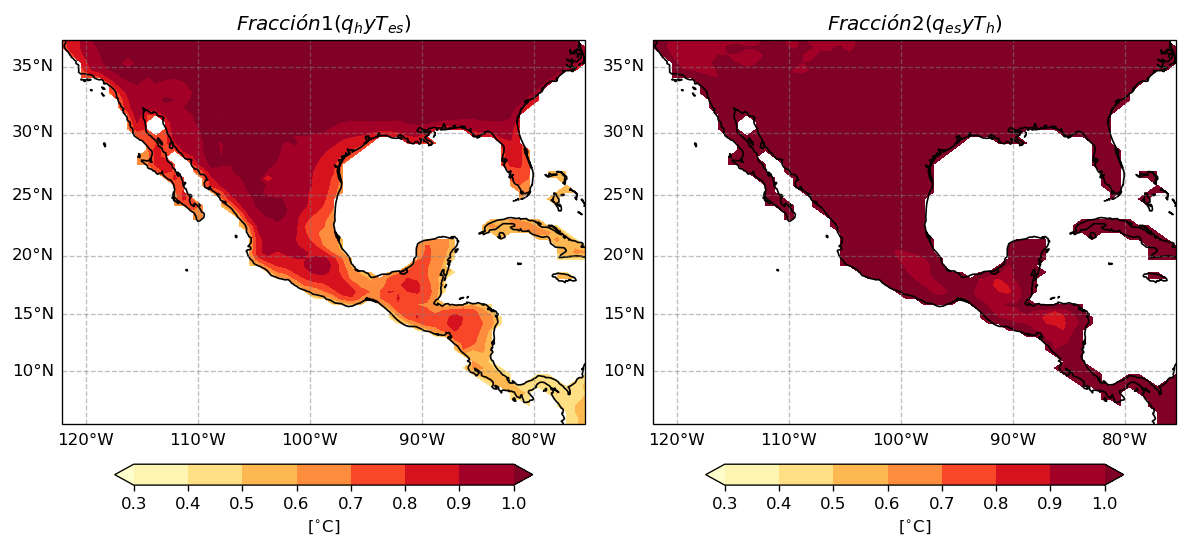

In [13]:
fig = plt.figure(figsize=(10, 7),dpi=120)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator())
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
ax.set_global
# fusion
levelss=np.arange(0.3,1.01,0.1)#np.linspace(frac1.min(),1,8)
x=frac1.lon
y=frac1.lat
c=frac1
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,extend="both",shrink=0.8,label='[$^{\circ}$C]',pad=0.05)
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
ax.set_title("$Fracción1 (q_{h} y T_{es})$")
#plt.savefig("Twmax.jpg")

ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator())
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
ax.set_global
# fusion
#levelss=np.linspace(frac2.min(),1,8)
x=frac2.lon
y=frac2.lat
c=frac2
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,extend="both",shrink=0.8,label='[$^{\circ}$C]',pad=0.05)
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
ax.set_title("$Fracción 2 (q_{es} y T_{h})$")
#plt.savefig("Twmax.jpg")

plt.tight_layout()
plt.show()

In [14]:
#GFDL
GFDL_histo=xr.open_dataset("cal_historical_GFDL.nc")
GFDL_ssp585=xr.open_dataset("cal_ssp585_GFDL.nc")

In [15]:
GFDL_histo=GFDL_histo.where(GFDL_histo.time.dt.year>1983,drop=True).mean("time")
GFDL_ssp585=GFDL_ssp585.where(GFDL_ssp585.time.dt.year>1969,drop=True).mean("time")

In [16]:
gfdl_histo=mask(GFDL_histo,1)
gfdl_ssp585=mask(GFDL_ssp585,1)

In [17]:
#qhistórica HadGEM
qh1=xr.open_dataset("twf_qh1_GFDL.nc")
qh_mask_GFDL=mask(qh1,1)

#qscenario HadGEM
qs1=xr.open_dataset("twf_qs1_GFDL.nc")
qs_mask_GFDL=mask(qs1,1)

In [18]:
#Abriendo los netcdf
Tqh_GFDL=qh_mask_GFDL
Tqs_GFDL=qs_mask_GFDL
TV_GFDL=gfdl_histo.Tw-273.15
TS_GFDL=gfdl_ssp585.Tw-273.15

In [19]:
#Delta entre escenario e histórico
d_TW1=TS_GFDL-TV_GFDL

In [20]:
#Fracción tomando en cuenta q histórica
frac1_gfdl=(Tqh_GFDL.__xarray_dataarray_variable__-TV_GFDL)/d_TW1

In [21]:
#Fracción tomando en cuenta q scenario
frac2_gfdl=(Tqs_GFDL.__xarray_dataarray_variable__-TV_GFDL)/d_TW1

In [22]:
frac1_gfdl

<xarray.DataArray (lat: 17, lon: 20)> Size: 3kB
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.4432509 , 0.54264371],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.46434086, 0.45834338, 0.51479449],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.46747441, 0.50175905, 0.47072258, 0.46442175, 0.48084067],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.58866724, 0.50327012,        nan,        nan, 0.44972699],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.48684458, 0.54953375,
        0.74784386, 0.56935506,        nan,        nan,        nan],
...
       [       nan,        nan,        nan, 0.66670669, 0.86095094,
        1.10244152, 1.2430141 , 1.27464181, 1.21619765, 1.19696604,
        1.15242179, 0.99882472, 0.85859824, 0.85156256, 0.78261376,
               nan, 0.81067964, 0.81508238,        nan,        nan],
       [       nan,        nan,        nan, 0.83047793, 0.94684218,
        1.30252191, 1.37856308, 1.37314538, 1.29489405, 1.26187361,
        1.26176253, 1.20922554, 1.13430104, 1.09300901, 1.02359591,
        0.98331517, 0.99548186, 0.88357782,        nan,        nan],
       [       nan,        nan, 0.69406668, 1.0173888 , 1.21111155,
        1.34304303, 1.44009245, 1.43698808, 1.35237267, 1.3361011 ,
        1.36282291, 1.3097048 , 1.22503907, 1.13948748, 1.07508678,
        1.0255966 , 1.00985412, 0.99444717, 0.85644014,        nan],
       [       nan, 0.72767524, 1.00633547, 1.18684679, 1.28372859,
        1.33533434, 1.33520612, 1.35659936, 1.37677531, 1.38716812,
        1.41118387, 1.3451614 , 1.19854066, 1.14854812, 1.11559054,
        1.10357232, 1.09887774, 1.04785622, 1.00540557, 0.88925865],
       [0.68159076, 0.84176129, 1.0893086 , 1.19792744, 1.25183389,
        1.28688182, 1.28374834, 1.32053183, 1.34102068, 1.39413908,
        1.42851702, 1.41064636, 1.3078911 , 1.25754481, 1.21385825,
        1.19772285, 1.20212447, 1.19629057, 1.12177845, 0.99304853]])
Coordinates:
  * lat        (lat) float64 136B 5.0 7.0 9.0 11.0 13.0 ... 31.0 33.0 35.0 37.0
  * lon        (lon) float64 160B 236.2 238.8 241.2 243.8 ... 278.8 281.2 283.8
    longitude  (lon) float64 160B 236.2 238.8 241.2 243.8 ... 278.8 281.2 283.8
    latitude   (lat) float64 136B 5.0 7.0 9.0 11.0 13.0 ... 31.0 33.0 35.0 37.0
    height     float64 8B 2.0

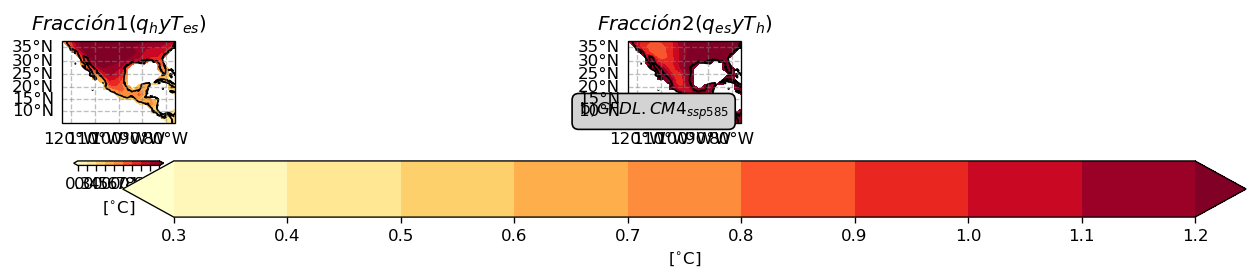

In [23]:
fig = plt.figure(figsize=(10, 7),dpi=120)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator())
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
ax.set_global
# fusion
levelss=np.arange(0.3,1.21,0.1)#np.linspace(frac1.min(),1,8)
x=frac1_gfdl.lon
y=frac1_gfdl.lat
c=frac1_gfdl
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,extend="both",shrink=0.8,label='[$^{\circ}$C]',pad=0.05)
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
ax.set_title("$Fracción1 (q_{h} y T_{es})$")
#plt.savefig("Twmax.jpg")

ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator())
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
ax.set_global
# fusion
#levelss=np.linspace(frac2.min(),1,8)
x=frac2_gfdl.lon
y=frac2_gfdl.lat
c=frac2_gfdl
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())

cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,extend="both",shrink=10,label='[$^{\circ}$C]',pad=0.05)
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
ax.set_title("$Fracción 2 (q_{es} y T_{h})$")
plt.text(-113, 10, "b)$GFDL.CM4_{ssp585}$", fontsize=10, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4),
        transform=ccrs.PlateCarree())
#plt.savefig("Twmax.jpg")

plt.tight_layout()
plt.show()

In [24]:
frac2_gfdl

<xarray.DataArray (lat: 17, lon: 20)> Size: 3kB
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 1.2226585 , 1.10946956],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 1.20301086, 1.21668737, 1.15463184],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        1.19244176, 1.1667062 , 1.20059582, 1.20315545, 1.19023849],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
        1.09883302, 1.17064817,        nan,        nan, 1.22034028],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 1.21868121, 1.16188626,
        0.96652519, 1.11681323,        nan,        nan,        nan],
...
       [       nan,        nan,        nan, 1.16966019, 1.16030211,
        1.07864728, 0.98261714, 0.93542013, 1.02621046, 1.15265897,
        1.26334084, 1.35720718, 1.37392691, 1.36185136, 1.34830388,
               nan, 1.31644154, 1.27701412,        nan,        nan],
       [       nan,        nan,        nan, 1.07270645, 1.12274604,
        0.89384634, 0.8710739 , 0.92061752, 1.02282413, 1.15091181,
        1.21876563, 1.31663323, 1.34903473, 1.34550343, 1.34853257,
        1.34665212, 1.32036874, 1.31344694,        nan,        nan],
       [       nan,        nan, 1.13524768, 0.9787271 , 0.8755536 ,
        0.83983694, 0.83841838, 0.94662813, 1.02816532, 1.12590694,
        1.19087469, 1.27633903, 1.32559419, 1.3652175 , 1.37452872,
        1.37249931, 1.35294264, 1.33924358, 1.33023423,        nan],
       [       nan, 1.08116225, 0.99822179, 0.89456572, 0.83633363,
        0.87569688, 0.87268789, 0.94236858, 1.03864592, 1.12693894,
        1.19451189, 1.2974918 , 1.4063708 , 1.42397516, 1.40957204,
        1.36533898, 1.30860738, 1.32419315, 1.34095169, 1.31058619],
       [1.07237453, 1.10143911, 0.96913243, 0.9282072 , 0.89268691,
        0.89406427, 0.92066925, 0.901667  , 1.06245784, 1.17760901,
        1.22608127, 1.30056676, 1.36214412, 1.37636436, 1.38934146,
        1.34597857, 1.27093456, 1.2119727 , 1.26673433, 1.28510715]])
Coordinates:
  * lat        (lat) float64 136B 5.0 7.0 9.0 11.0 13.0 ... 31.0 33.0 35.0 37.0
  * lon        (lon) float64 160B 236.2 238.8 241.2 243.8 ... 278.8 281.2 283.8
    longitude  (lon) float64 160B 236.2 238.8 241.2 243.8 ... 278.8 281.2 283.8
    latitude   (lat) float64 136B 5.0 7.0 9.0 11.0 13.0 ... 31.0 33.0 35.0 37.0
    height     float64 8B 2.0

In [25]:
def add_map_colorbar(pos,axis,labelsita,fig,cs):
        # posicion pos
        # axis 
        # label del coorbar
        # objeto de figura (fig)
        # resultado o barra colorear
        cbar_ax = fig.add_axes(axis)
        cbar=fig.colorbar(cs, cax=cbar_ax,orientation=pos,shrink=10)
        cbar.ax.tick_params(labelsize=10)
        if labelsita!=None:
                cbar.set_label(label=labelsita,fontsize=13)
        return cbar

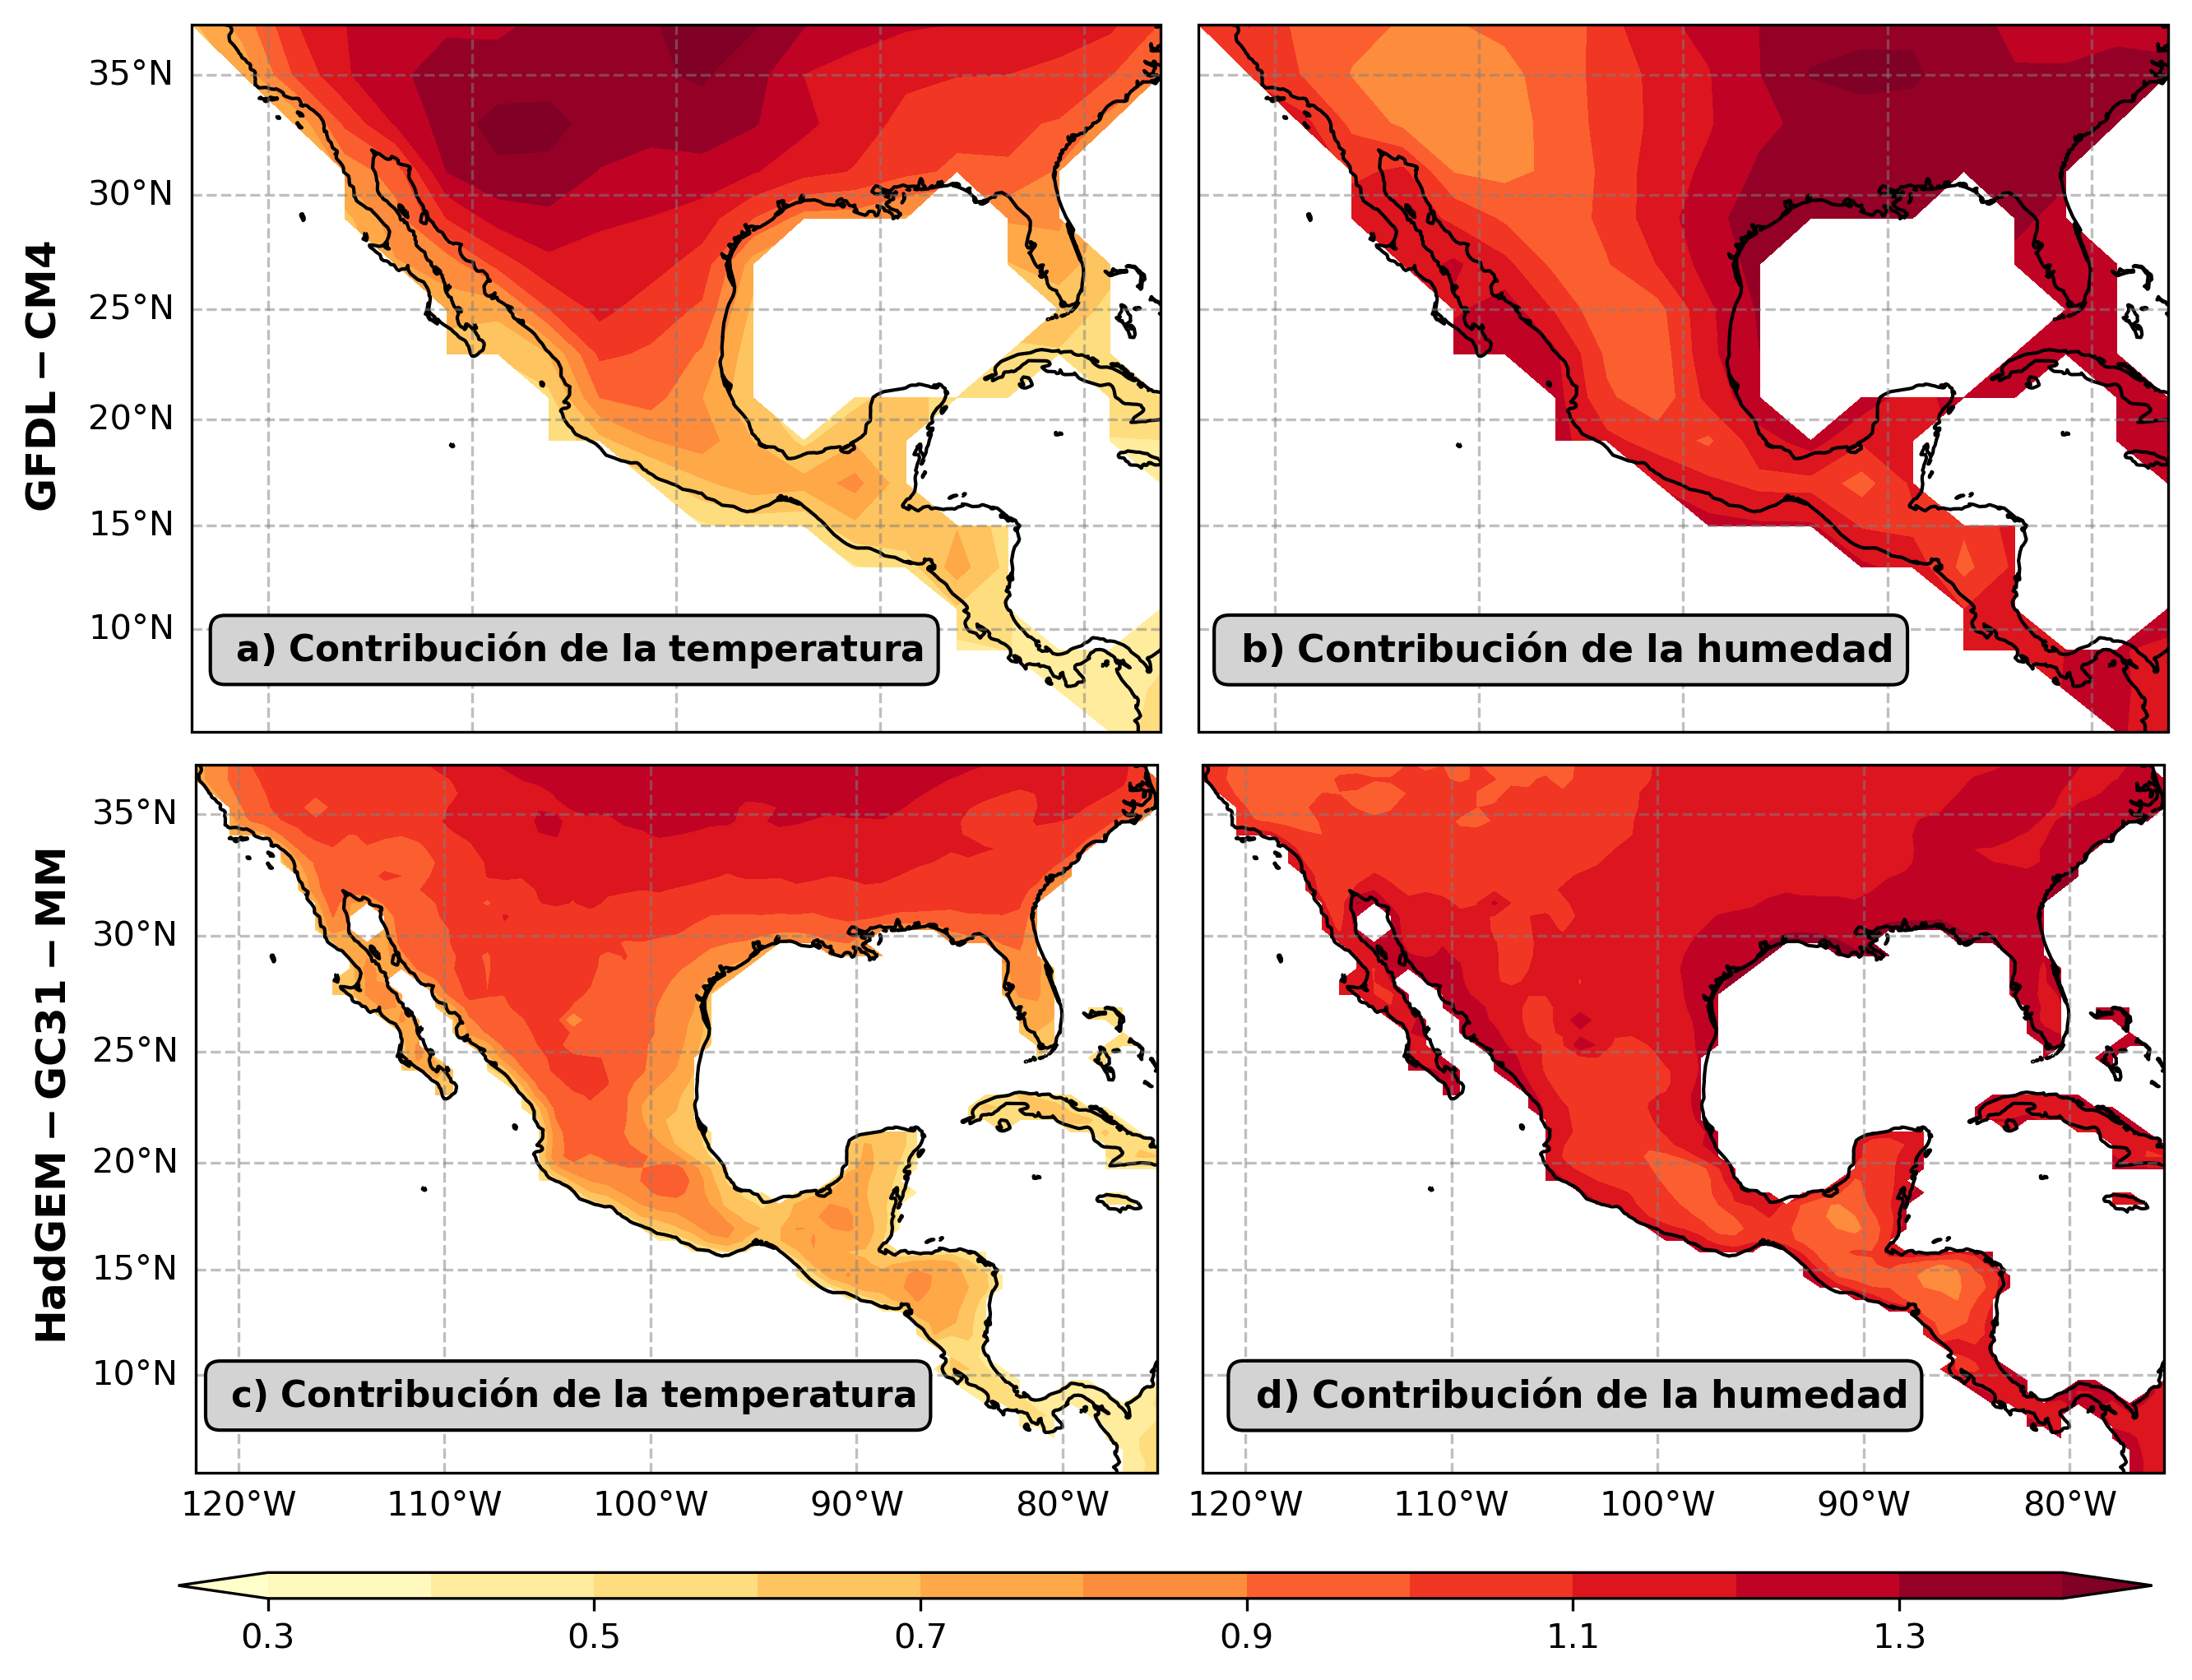

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

# Crear figura
fig = plt.figure(figsize=(10, 7), dpi=300)



# Definir niveles comunes para ambos mapas
levelss = np.arange(0.3, 1.5, 0.1)

# ----- MAPA 1 -----
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.Mercator())
 # Recorte opcional
x1, y1, c1 = frac1_gfdl.lon, frac1_gfdl.lat, frac1_gfdl
cs1 = ax1.contourf(x1, y1, c1, cmap="YlOrRd", levels=levelss, extend='both', transform=ccrs.PlateCarree())
plt.text(-105, 9,  r' $\mathbf{a)}$ $\mathbf{Contribución }$ $\mathbf{de}$ $\mathbf{la}$ $\mathbf{temperatura}$', fontsize=10.5, color="black",
    ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round", pad=0.4),
    transform=ccrs.PlateCarree())
ax1.coastlines()
ax.add_feature(cfeature.BORDERS)
gl1 = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = gl1.right_labels = gl1.bottom_labels=False
ax1.text(-130, 22, r'$\mathbf{GFDL-CM4}$',fontsize=12, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ccrs.PlateCarree())


# ----- MAPA 2 -----
ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.Mercator())
  # Recorte opcional
x2, y2, c2 = frac2_gfdl.lon, frac2_gfdl.lat, frac2_gfdl
cs2 = ax2.contourf(x2, y2, c2, cmap="YlOrRd", levels=levelss,  extend='both', transform=ccrs.PlateCarree())
plt.text(-106, 9, r' $\mathbf{b)}$ $\mathbf{Contribución }$ $\mathbf{de}$ $\mathbf{la}$ $\mathbf{ humedad}$' ,color="black",fontsize=11,
    ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round", pad=0.4),
    transform=ccrs.PlateCarree())
ax2.coastlines()
ax.add_feature(cfeature.BORDERS)
gl2 = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = gl2.right_labels = False
gl2.left_labels=gl2.bottom_labels=False
#ax2.set_title("$Fracción 2 (q_{es} y T_{h})$")



# Añadir anotación en el mapa 2

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.Mercator())
 # Recorte opcional
x3, y3, c3 = frac1.lon, frac1.lat, frac1
cs3 = ax3.contourf(x3, y3, c3, cmap="YlOrRd", levels=levelss, extend='both', transform=ccrs.PlateCarree())
plt.text(-104, 9,  r' $\mathbf{c)}$ $\mathbf{Contribución }$ $\mathbf{de}$ $\mathbf{la}$ $\mathbf{temperatura}$' , fontsize=10.5, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round", pad=0.4),
    transform=ccrs.PlateCarree())
ax3.coastlines()
ax.add_feature(cfeature.BORDERS)
gl3 = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='gray', alpha=0.5, linestyle='--')
gl3.top_labels = gl3.right_labels = False
ax3.minorticks_on()
#ax3.set_title("$Fracción 1 (q_{h} y T_{es})$")
ax3.text(-128, 23, r'$\mathbf{HadGEM-GC31-MM}$',fontsize=12, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ccrs.PlateCarree())

# ----- MAPA 4 -----
ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.Mercator())

x4, y4, c4 = frac2.lon, frac2.lat, frac2
cs4 = ax4.contourf(x4, y4, c4, cmap="YlOrRd", levels=levelss, extend='both', transform=ccrs.PlateCarree())

ax4.coastlines()
ax.add_feature(cfeature.BORDERS)
gl4 = ax4.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl4.top_labels = gl4.right_labels = False

gl4.bottom_labels = True  # Mostrar etiquetas abajo
gl4.left_labels = False
#ax4.set_title("$Fracción 1 (q_{h} y T_{es})$")
# Añadir anotación en el mapa 2
plt.text(-104, 9, r' $\mathbf{d)}$ $\mathbf{Contribución }$ $\mathbf{de}$ $\mathbf{la}$ $\mathbf{humedad}$' , fontsize=11, color="black",
    ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round", pad=0.4),
    transform=ccrs.PlateCarree())
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,bottom=0.14)
# Barra de colores compartida
add_map_colorbar('horizontal',[0.12,0.067,0.8,0.015],None,fig,cs1)
#cbar = fig.colorbar(cs1, ax=[ax1, ax2,ax3,ax4], orientation='horizontal', fraction=0.08,shrink=0.5, extend="both")
#cbar.set_label('[$^{\circ}$C]')
# Ajustar diseño y mostrar

plt.savefig("fraction_contribution_models.svg",bbox_inches="tight",dpi=300)

plt.savefig("fraction_contribution_models.png",bbox_inches="tight",dpi=300)